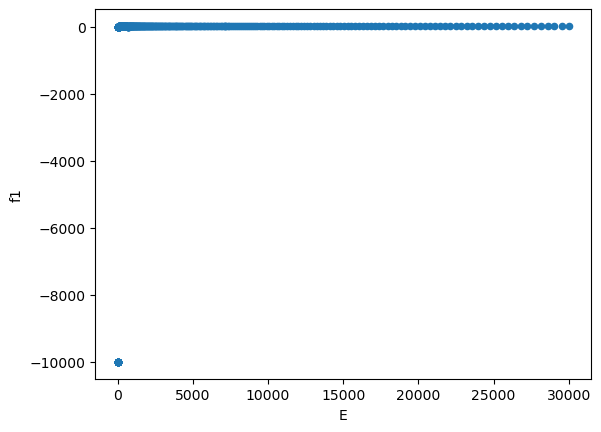

In [214]:
import requests
import pandas as pd
from io import StringIO
import numpy
import scipy

element = 'fe' #소문자로 작성

# Send an HTTP GET request to the URL
response = requests.get('https://henke.lbl.gov/optical_constants/sf/'+element+'.nff')
if response.status_code == 200:
    content = StringIO(response.text)
    df = pd.read_csv(content, sep='\t')
else: print("에러")
    
df = df.reset_index()
df = df.drop('f2',axis = 1)
df.columns = ['E','f1','f2']
df = df.assign(newf1=np.nan)
df.plot(kind = 'scatter',x='E', y='f1')
plt.show()

#kk함수
# 2/pi()*
    


In [77]:
import numpy
import scipy

result = scipy.integrate.quad(lambda x: 1/(x**2), 0.1, 4.5)
result

(9.777777777777782, 5.164764455447125e-09)

C:\Users\chlrk\AppData\Local\Temp\ipykernel_2300\3626043614.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_result, _ = integrate.quad(integrand, -np.inf, np.inf)
C:\Users\chlrk\AppData\Local\Temp\ipykernel_2300\3626043614.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_result, _ = integrate.quad(integrand, -np.inf, np.inf)


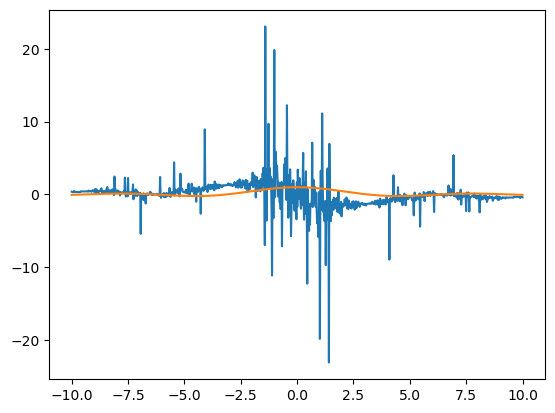

In [86]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def kramers_kronig(w, f_im):
    def integrand(w_prime):
        return f_im(w_prime) / (w_prime - w)
    
    integral_result, _ = integrate.quad(integrand, -np.inf, np.inf)
    return (2 / np.pi) * integral_result

# Replace this with your actual data
def f_im(w):
    # Replace this with the equation for the imaginary part of your function
    return np.sin(w) / w

w_values = np.linspace(-10, 10, 1000)
f_re_values = [kramers_kronig(w, f_im) for w in w_values]

# Now f_re_values contains the real part computed using Kramers-Kronig relation
plt.plot(w_values, f_re_values, w_values, f_im(w_values))
plt.show()

In [82]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

#make f1 function
def kk_relat_getf1(w_n,f,w1,w2): #w_n은 현재 위치, w1,w2는 구간의 값
    def integrand(w):
        return f(w) * w_n / (w**2 - w_n**2)
    integral_result, _ = integrate.quad(integrand, w1, w2)
    return (-2 / np.pi) * integral_result


lastpoint = len(df) - 1
low_expol_a = df.loc[0,'f2']/df.loc[0,'E']**2
high_expol_a = df.loc[lastpoint,'f2']*df.loc[lastpoint,'E']
for i in range(len(df)):
    w_n=df.loc[i,'E']
    kk_sum = 0
    kk_sum += kk_relat_getf1(w_n,lambda w:low_expol_a*w**2,0,df.loc[0,'E']) #초반 외삽
    for j in range(len(df)-1):
        if j == i or i-1: #포인트 근처에서 2차식으로 근사해서 구하자.
            if i == 0:
                b = 2*low_expol_a*df.loc[0,'E']
                kk_sum += b*(df.loc[1,'E']-df.loc[0,'E']) #틀린것이다.
            elif i == lastpoint:
                b = -1*high_expol_a*df.loc[lastpoint,'E']**-2
                kk_sum += b*(df.loc[lastpoint,'E']-df.loc[lastpoint-1,'E'])
            else: # 기본적으로 2차식을 풀어서 계산해서 더한다.
                w0 = df.loc[i-1,'E']; w1 = df.loc[i,'E']; w2 = df.loc[i+1,'E']
                f0 = df.loc[i-1,'f2']; f1 = df.loc[i,'f2']; f2 = df.loc[i+1,'f2']
                x1=w0-w1; x2=w2-w1; y1=f0-f1; y2=f2-f1
                b = (y1/x1**2-y2/x2**2)/(1/x1-1/x2)
                a = (y1/x1-y2/x1)/(x1-x2)
                integral_a, _ = integrate.quad(lambda w : a*(w-w1)/(w+w1)*w_n, w0, w2)
                integral_b, _ = integrate.quad(lambda w : b/(w+w1)*w_n, w0, w2)
                integral_c = f1/2*(np.log(w2**2-w1**2)-np.log(w1**2-w0**2))
                kk_sum += (2 / np.pi)*(integral_a+integral_b+integral_c)/2 #j는 두번 반복될 것이므로 2로 나눈다.
        else :
            x1 = df.loc[j,'E']; x2 = df.loc[j+1,'E']; y1 = df.loc[j,'f2']; y2 = df.loc[j+1,'f2']
            kk_sum += kk_relat_getf1(w_n,lambda w:(y2-y1)/(x2-x1)*(w-x1)+y1,x1,x2) #중간부분은 대충 리니어로 보간해서 적분했다.
    kk_sum += kk_relat_getf1(w_n,lambda w:low_expol_a/w,df.loc[lastpoint,'E'],np.inf) #후반 외삽
    df.loc[i,'newf1'] = kk_sum*w_n

    
pd.set_option('display.max_rows', None)
df
# df.plot(kind = 'scatter',x='E', y='f1')
# plt.show()
# df.plot(kind = 'scatter',x='E', y='newf1')
# plt.show()

C:\Users\chlrk\AppData\Local\Temp\ipykernel_24280\781015427.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  return f(w) * w_n / (w**2 - w_n**2)
C:\Users\chlrk\AppData\Local\Temp\ipykernel_24280\781015427.py:9: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral_result, _ = integrate.quad(integrand, w1, w2)
C:\Users\chlrk\AppData\Local\Temp\ipykernel_24280\781015427.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_result, _ = integrate.quad(integrand, w1, w2)
C:\Users\chlrk\AppData\Local\Temp\ipykernel_24280\781015427.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting 

,E,f1,f2,newf1
0,10.0000,-9999.000000,1.185660,-inf
1,10.1617,-9999.000000,1.229410,-inf
2,10.3261,-9999.000000,1.274780,1.194166e+02
3,10.4931,-9999.000000,1.321820,1.340942e+02
4,10.6628,-9999.000000,1.382150,1.598290e+02
5,10.8353,-9999.000000,1.455410,1.782421e+02
6,11.0106,-9999.000000,1.532560,1.887585e+02
7,11.1886,-9999.000000,1.613790,2.031534e+02
8,11.3696,-9999.000000,1.699330,2.138197e+02
9,11.5535,-9999.000000,1.787550,2.263674e+02


In [155]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

#make f1 function
def kk_relat_getf1(w_n,f,w1,w2): #w_n은 현재 위치, w1,w2는 구간의 값
    def integrand(w):
        return f(w) * w / (w**2 - w_n**2)
    integral_result, _ = integrate.quad(integrand, w1, w2)
    return (2 / np.pi) * integral_result
low_expol_a = 3
w_n=df.loc[2,'E']
kk_sum = 0
kk_sum += kk_relat_getf1(w_n,lambda w : low_expol_a*w**2, 0, df.loc[0,'E'])
print(kk_sum)    

-187.3695877661717


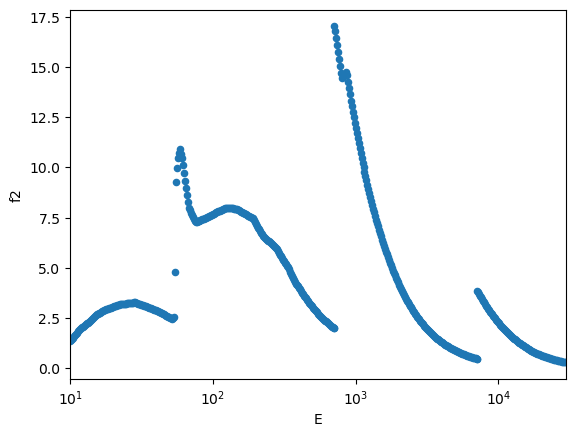

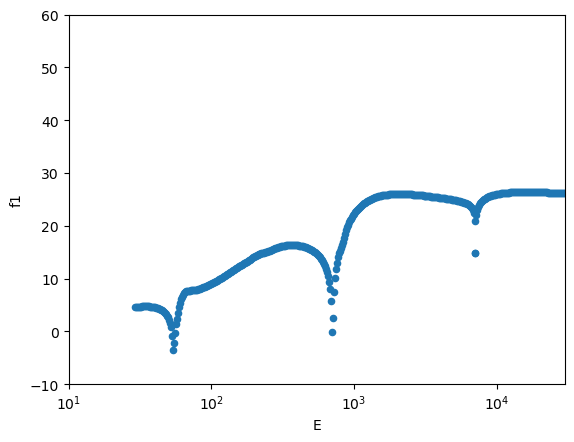

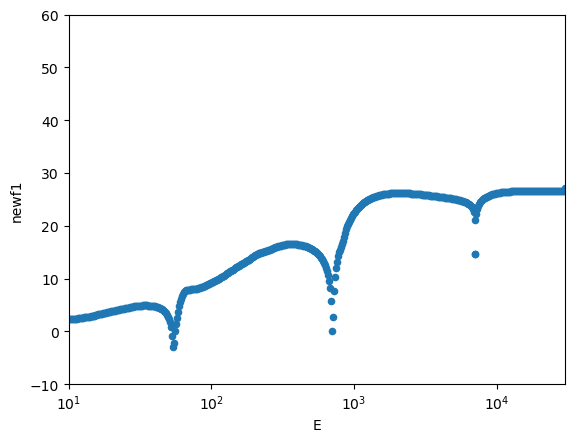

In [222]:

df.plot(kind = 'scatter',x='E', y='f2')
plt.xscale('symlog')
plt.xlim([10, 30000])
# plt.ylim([0, 30])
plt.show()
df.plot(kind = 'scatter',x='E', y='f1')
plt.xlim([10, 30000])
plt.xscale('symlog')
plt.ylim([-10, 60])
plt.show()
df.plot(kind = 'scatter',x='E', y='newf1')
plt.xscale('symlog')
plt.xlim([10, 30000])
plt.ylim([-10, 60])
plt.show()


In [191]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt


def kk_relat_getf1(w_n,f,w1,w2): #w_n은 현재 위치, w1,w2는 구간의 값
    def integrand(w):
        return f(w) * w / (w**2 - w_n**2)
    integral_result, _ = integrate.quad(integrand, w1, w2)
    return (2 / np.pi) * integral_result

def g(x,y):
    if x==y:
        return (x+y)*np.log(x+y)
    else:
        return (x+y)*np.log(x+y)+(x-y)*np.log(np.abs(x-y))

# 리핏 메뉴얼에 적혀있는 방법
def kk_linearfit(w,w0,w1,w2):
    return 1/np.pi*(g(w0,w)/(w1-w0)-(w2-w0)*g(w1,w)/(w1-w0)/(w2-w1)+g(w2,w)/(w2-w1))


lastpoint = len(df) - 1
low_expol_a = df.loc[0,'f2']/df.loc[0,'E']**2
high_expol_a = df.loc[lastpoint,'f2']*df.loc[lastpoint,'E']
for i in range(len(df)):
    w_n=df.loc[i,'E']
    kk_sum = 0
#     kk_sum += kk_relat_getf1(w_n,lambda w:low_expol_a*w**2,0,df.loc[0,'E']) #초반 외삽
    for j in range(len(df)):
        if j==0:
            x1 = df.loc[0,'E']; x2 = df.loc[1,'E']; y1 = df.loc[0,'f2']; y2 = 0
            if i != j:
                a=1
#                 kk_sum += kk_relat_getf1(w_n,lambda w:(y2-y1)/(x2-x1)*(w-x1)+y1,x1,x2)
        elif j==lastpoint:
            x1 = df.loc[lastpoint-1,'E']; x2 = df.loc[lastpoint,'E']; y1 = 0; y2 = df.loc[lastpoint,'f2']
            if i != j:
                a=1
#                 kk_sum += kk_relat_getf1(w_n,lambda w:(y2-y1)/(x2-x1)*(w-x1)+y1,x1,x2)
        else:
            x0 = df.loc[j-1,'E']; x1 = df.loc[j,'E']; x2 = df.loc[j+1,'E']; y = df.loc[j,'f2']
            kk_sum += y * kk_linearfit(w_n,x0,x1,x2)
#     kk_sum += kk_relat_getf1(w_n,lambda w:low_expol_a/w,df.loc[lastpoint,'E'],np.inf) #후반 외삽
    df.loc[i,'newf1'] = -1*kk_sum

    
pd.set_option('display.max_rows', 10)
df
# df.plot(kind = 'scatter',x='E', y='f1')
# plt.show()
# df.plot(kind = 'scatter',x='E', y='newf1')
# plt.show()

,E,f1,f2,newf1
0,10.0000,-9999.0000,1.18566,-50.061221
1,10.1617,-9999.0000,1.22941,-50.169825
2,10.3261,-9999.0000,1.27478,-49.737484
3,10.4931,-9999.0000,1.32182,-49.633933
4,10.6628,-9999.0000,1.38215,-49.602147
...,...,...,...,...
503,28135.1000,45.6872,3.05314,1.358712
504,28590.2000,45.8492,2.97550,1.766895
505,29052.6000,45.9888,2.89948,2.306099
506,29522.5000,46.1180,2.82506,3.570513


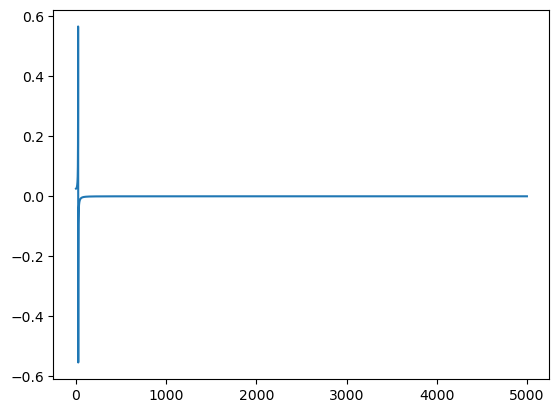

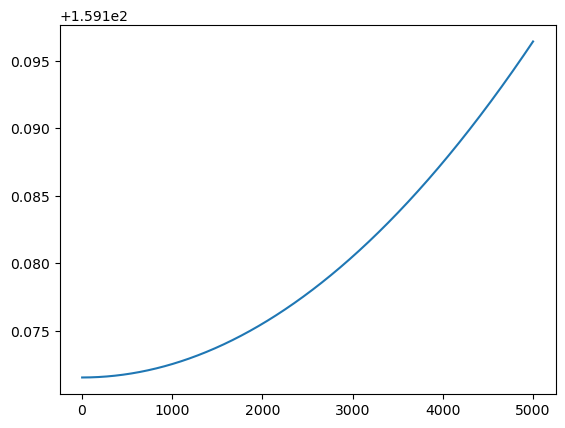

In [19]:
import numpy as np
import matplotlib.pyplot as plt
def kk_linearfit(w,w0,w1,w2):
    def g(x,y):
        if x == y:
            return (x+y)*np.log(x+y)
        else:
            return (x+y)*np.log(x+y)+(x-y)*np.log(np.abs(x-y))
    return 1/np.pi*(g(w0,w)/(w1-w0)-(w2-w0)*g(w1,w)/(w1-w0)/(w2-w1)+g(w2,w)/(w2-w1))

x = np.linspace(1, 5000, 20000)
a = []
for i in x:
    a.append(kk_linearfit(i,24,25,26))
# print(kk_linearfit(np.inf,24,25,26))

plt.plot(x,a)
plt.show()

x = np.linspace(1, 5000, 20000)
a = []
for i in x:
    a.append(kk_linearfit(i,390000,400000,410000)*10000)
# print(kk_linearfit(np.inf,24,25,26))

plt.plot(x,a)
plt.show()

In [220]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def g(x,y):
    if x==y:
        return (x+y)*np.log(x+y)
    else:
        return (x+y)*np.log(x+y)+(x-y)*np.log(np.abs(x-y))

# 리핏 메뉴얼에 적혀있는 방법인데 내가 수정(리핏틀림!)
def kk_linearfit(w,w0,w1,w2):
    return 1/np.pi*(g(w0,w)/(w1-w0)-(w2-w0)*g(w1,w)/(w1-w0)/(w2-w1)+g(w2,w)/(w2-w1))

# 초반 외삽 (x^2으로 피팅)
def kk_expol_front(w,w1,w2):
    def f(w,w1,w2):
        if -1*w == w1:
            return 0
        else:
            return (w**2/w1**2-(w2+w)/(w2-w1))*np.log(np.abs(w1+w))
    return 1/np.pi*(-1-2*w**2/w1**2*np.log(w)+g(w2,w)/(w2-w1)+f(w,w1,w2)+f(-1*w,w1,w2))

# 후반 외삽 (x^-1으로 피팅)
def kk_expol_end(w,w0,w1):
    def f(w,w0,w1):
        if -1*w == w1:
            return 0
        else:
            return (w1/w**2-(w0+w)/(w1-w0))*np.log(np.abs(w1+w))
    return 1/np.pi*(2-2*w1/w**2*np.log(w1)+g(w0,w)/(w1-w0)+f(w,w0,w1)+f(-1*w,w0,w1))


lastpoint = len(df) - 1
low_expol_a = df.loc[0,'f2']/df.loc[0,'E']**2
high_expol_a = df.loc[lastpoint,'f2']*df.loc[lastpoint,'E']
for i in range(len(df)):
    w_n=df.loc[i,'E']
    kk_sum = 0
    for j in range(len(df)):
        if j==0:
            x1 = df.loc[0,'E']; x2 = df.loc[1,'E']; y = df.loc[0,'f2']
            kk_sum += y * kk_expol_front(w_n,x1,x2)
        elif j==lastpoint:
            x0 = df.loc[j-1,'E']; x1 = df.loc[j,'E']; y = df.loc[j,'f2']
            kk_sum += y * kk_expol_end(w_n,x0,x1)
        else:
            x0 = df.loc[j-1,'E']; x1 = df.loc[j,'E']; x2 = df.loc[j+1,'E']; y = df.loc[j,'f2']
            kk_sum += y * kk_linearfit(w_n,x0,x1,x2)
    df.loc[i,'newf1'] = -1*kk_sum + 26
    
df

,E,f1,f2,newf1
0,10.0000,-9999.000000,1.378520,2.358361
1,10.1617,-9999.000000,1.429610,2.351855
2,10.3261,-9999.000000,1.482590,2.349237
3,10.4931,-9999.000000,1.537540,2.349289
4,10.6628,-9999.000000,1.594530,2.352077
5,10.8353,-9999.000000,1.653620,2.357888
6,11.0106,-9999.000000,1.714910,2.367225
7,11.1886,-9999.000000,1.778470,2.380965
8,11.3696,-9999.000000,1.844380,2.400631
9,11.5535,-9999.000000,1.912740,2.430689
